In [39]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

csv_dataset = 'Dataset Initializing/Variant Results Stripped.csv'
dataset = pd.read_csv(csv_dataset)
vectors = pd.DataFrame()
Ref_Alt_Dict = {'A':0, 'T':1, 'C':2, 'G':3}

In [79]:
#initializing the max value of the raw scores
RawScore_max = max(max(dataset['RawScore_A']),
max(dataset['RawScore_C']),
max(dataset['RawScore_T']),
max(dataset['RawScore_G']))

#initializing vectors
for index in range(dataset.shape[0]):
    vectors.loc[index, "RawScore_A"] = 1/(1+math.exp(-1*float(dataset.loc[index, "RawScore_A"])/RawScore_max))
    vectors.loc[index, "RawScore_T"] = 1/(1+math.exp(-1*float(dataset.loc[index, "RawScore_T"])/RawScore_max))
    vectors.loc[index, "RawScore_C"] = 1/(1+math.exp(-1*float(dataset.loc[index, "RawScore_C"])/RawScore_max))
    vectors.loc[index, "RawScore_G"] = 1/(1+math.exp(-1*float(dataset.loc[index, "RawScore_G"])/RawScore_max))
    if str(dataset.loc[index, "Phenotype"]) == 'nan':
        vectors.loc[index, "Label"] = 0
    else:
        vectors.loc[index, "Label"] = 1
    vectors.loc[index, "Control"] = str(dataset.loc[index, "Chromosome"]) + '.' +str(dataset.loc[index, "NTPosition"]) + '.' +dataset.loc[index, "NTChange"]

vectors.head()

,RawScore_A,RawScore_T,RawScore_C,RawScore_G,Label,Control
0,0.564738,0.577325,0.500000,0.580218,1.0,19.13506221.C>A
1,0.588046,0.587968,0.576281,0.500000,1.0,19.13506220.G>A
2,0.583085,0.573855,0.574739,0.500000,1.0,19.13506218.G>A
3,0.583085,0.573855,0.574739,0.500000,1.0,19.13506218.G>C
4,0.570248,0.569068,0.500000,0.567532,0.0,19.13506211.C>A


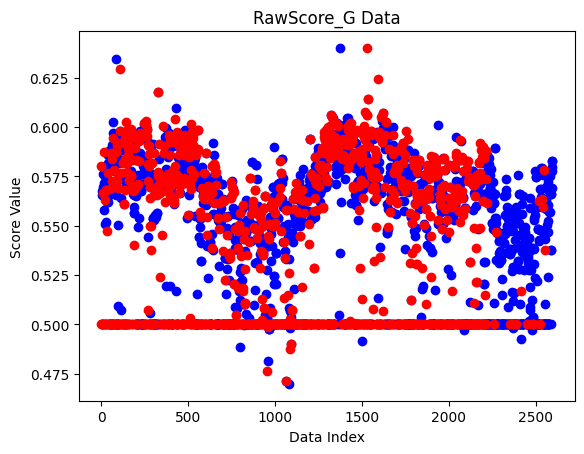

In [80]:
#data visualizing
column = 'RawScore_G'
pos = np.array([[vectors[column].index[int(disease[0])], vectors[column][int(disease[0])]] for disease in enumerate(vectors['Label']) if disease[1]])
neg = np.array([[vectors[column].index[int(disease[0])], vectors[column][int(disease[0])]] for disease in enumerate(vectors['Label']) if not(disease[1])])


plt1 = plt.scatter([int(i) for i in neg.T[0]], [float(i) for i in neg.T[1]], c='b')
plt1 = plt.scatter([int(i) for i in pos.T[0]], [float(i) for i in pos.T[1]], c='r')
plt.title(column + " Data")
plt.xlabel("Data Index")
plt.ylabel("Score Value")

plt.show(plt1)


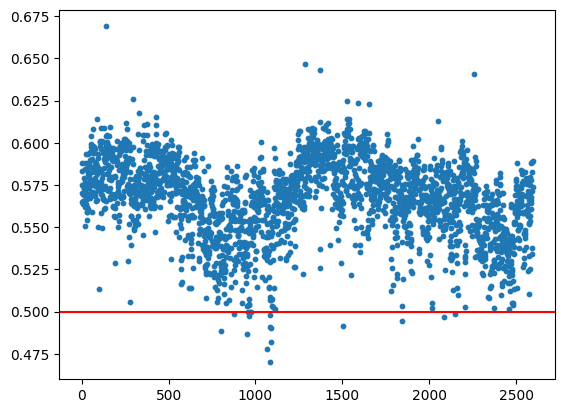

In [81]:
#variant data visualizing
Alt_vector = np.array([[index, vectors[vectors.columns[Ref_Alt_Dict[vectors['Control'][index][-1]]]][index]] for index in range(vectors.shape[0])])
Alt_vector = Alt_vector.T
Alt_vector[1]

plt2 = plt.scatter(Alt_vector[0], Alt_vector[1], s=10)
plt2 = plt.axline((0, 0.5), (Alt_vector[0][-1], 0.5), c='r')
plt.show(plt2)

In [82]:
# Neg_values = [[vectors['RawScore_A'][index], vectors['RawScore_T'][index], vectors['RawScore_C'][index], vectors['RawScore_G'][index], Alt_vector[1][index], vectors['Control'][index]] for index in range(Alt_vector.shape[1]) if Alt_vector[1][index] < 0.5]
Neg_values = [vectors['Control'][index] for index in range(Alt_vector.shape[1]) if Alt_vector[1][index] < 0.5]
Neg_values

['19.13298865.C>G',
 '19.13298728.G>C',
 '19.13298599.T>C',
 '19.13298590.C>T',
 '19.13298584.C>G',
 '19.13298584.C>T',
 '19.13298573.C>G',
 '19.13286794.C>T',
 '19.13286739.A>G',
 '19.13286740.T>C',
 '19.13286736.A>G',
 '19.13286722.T>G',
 '19.13286722.T>C',
 '19.13253020.C>G',
 '19.13212427.T>C',
 '19.13208909.C>G',
 '19.13208851.C>T']

In [13]:
"""
- plots of variant only vs label,
- try one of these models:
- SVM(RBF)
- XGBoost
- Ridge
- LASSO
"""

(2597, 6)